Today I'm adding "time in range" to my daily stats. Time in range means: how much time was Alma's glucose within her (current) target range of 70-180 mg/dL? And is the time in range related to the amount of insulin she's getting per day? This probably seems kind of trivial and silly, but it's actually kind of tough to figure out what's going on because she may or may not be in the "honeymoon" stage, which means the last few beta cells in her pancreas may still be making insulin. But not in a regular, predictable way.  

## TL;DR

Once again - because the code is not for everyone - here's the overview. This first plot is showing Alma's time in range over each day, as a percentage of the whole day, in the bright blue color. So 100% means she's had a blood glucose reading between 70-180 mg/dL for the entire day. And 0% means she hasn't been in that range at all. The red bars show her time below the target range, and the pale blue/gray bars show time above the target range. 

This plot covers a time span of a bit over a month, and you can see that over time she does have more time in range, especially in the time period after about February 20th. This happens to coincide very closely with the date when we switched Alma's insulin pump from automatic to manual mode. The numbers on about March 3-4 have a lot of time in range, but it was a weird couple of days because Alma had a stomach bug and for some reason had really low insulin needs, making it way easier than normal to keep her in range. 

<div>
<img src="../assets/images/2023.03.06-plot01.png"/>
</blockquote>

In the next plot I'm trying to break that down even more. This time I'm plotting time in range as a function of the amount of insulin she was getting each day. I'm also coloring the dots based on some categories that I set manually, including time when the pump was in manual mode (that would be the first and largest section, as well as time when the pump was in automated mode. I also noted the days when she was sick, and then when she got better.  

<div>
<img src="../assets/images/2023.03.06-plot02.png"/>
</div>

I think this is really interesting because the different categories sort of split out into clusters. The time period when her pump was in manual mode was really variable, and maybe very loosely characterized by lower daily insulin amounts. After starting the pump, her percent time in range went up noticeably, as did her daily insulin. I should probably note that this shift was not really entirely due to starting automated mode (although that helped) but it was more because I started to shift her meal-time insulin (i.e. her carb ratios) to higher doses since she was spiking really high after every meal. When she got sick, she was suddenly in range pretty much all the time. She also barely needed any insulin at that time, which you can see from the plot. Interestingly, this trend hung on for a few days after she recovered. 


## The long version:

In [1]:
# IMPORTS

# since this notebook lives in a sub-folder of the main project, I'll add the main folder to the python path
import sys
sys.path.append("../")

# Load my modules
from tools.glooko import read_all
from tools.stats import get_yeardays

# Load extra stuff that I need
import numpy as np
import pandas as pd

# Plotting (matplotlib widget allows for interactivity in the live notebook)
import matplotlib.pyplot as plt
%matplotlib widget


In [2]:
# GET UNIQUE DAYS

df_cgm, df_bolus, df_basal, df_insulin, df_cgm_daily = read_all(r"../data/glooko/")
df_cgm["yearday"] = get_yeardays(df_cgm)
df_insulin["yearday"] = get_yeardays(df_insulin)

# COMPUTE STATS PER DAY
df_cgm_summary = df_cgm[["bg", "yearday"]].groupby("yearday").describe()["bg"]

df_cgm_summary["yearday"] = df_cgm_summary.index
df_cgm_summary["time"] = pd.to_datetime(df_cgm_summary['yearday'], format='%Y-%j')

In [5]:
# COMPUTE DAILY TIME IN RANGE
min_target = 70
max_target = 180

unique_days = df_cgm_summary["yearday"].tolist()

# Initialize lists
pct_above = []
pct_below = []
pct_inrange = []

# loop through each day (I'm sure there's a fancy way to do this with Pandas but I 
# can't figure it out...)
for day in unique_days:
    df_sub = df_cgm[df_cgm["yearday"]==day]
    this_total = len(df_sub)
    if this_total > 0:
        pct_above.append(sum(df_sub["bg"]>max_target)/this_total*100)
        pct_below.append(sum(df_sub["bg"]<=min_target)/this_total*100)
        pct_inrange.append(sum((df_sub["bg"] > min_target) & (df_sub["bg"] <= max_target))/this_total*100)
    else:
        pct_above.append(0)
        pct_below.append(0)
        pct_inrange.append(0)
        
df_cgm_summary["pct_above"] = pct_above
df_cgm_summary["pct_below"] = pct_below
df_cgm_summary["pct_inrange"] = pct_inrange

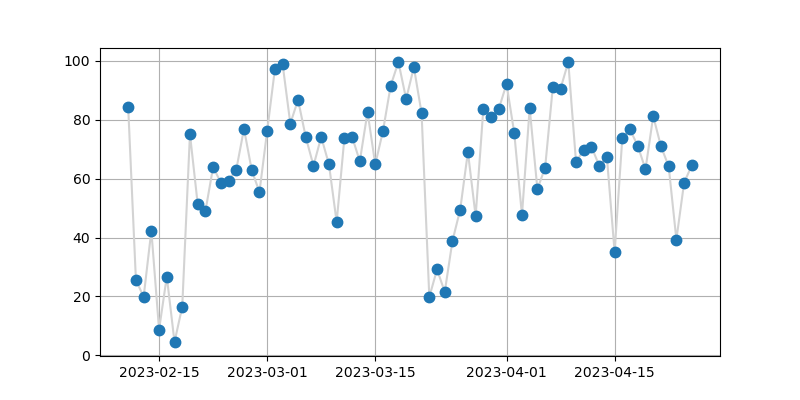

In [6]:
## Plotting percent time in range
fig,ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(df_cgm_summary["time"], df_cgm_summary["pct_inrange"],color="lightgray")
ax.plot(df_cgm_summary["time"], df_cgm_summary["pct_inrange"],'.', markersize=15)
plt.grid()

Text(0.5, 1.0, 'Target range: 70 - 180 mg/dL')

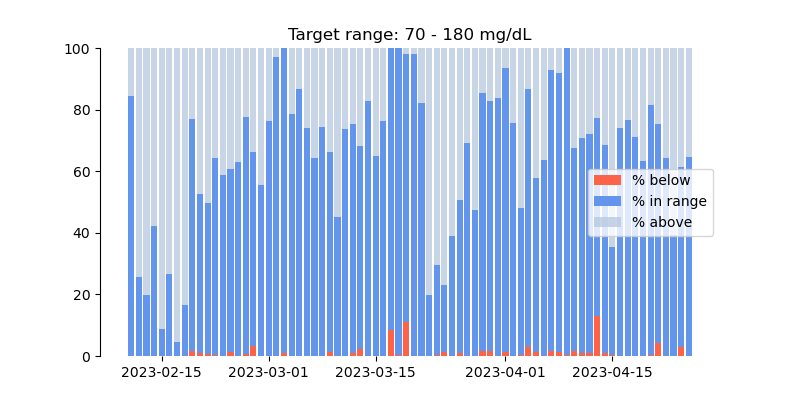

In [7]:
## Bar plot
import seaborn as sns

fig2, ax2 = plt.subplots(1,1, figsize=(8,4))

ax2.bar(df_cgm_summary["time"], df_cgm_summary["pct_below"], 
        color="tomato", alpha=1, label="% below")

ax2.bar(df_cgm_summary["time"], df_cgm_summary["pct_inrange"], 
        bottom=df_cgm_summary["pct_below"],
        color="cornflowerblue", alpha=1, label="% in range")

ax2.bar(df_cgm_summary["time"], df_cgm_summary["pct_above"], 
        bottom=df_cgm_summary["pct_below"] + df_cgm_summary["pct_inrange"],
        color="lightsteelblue", alpha=0.7, label="% above")

ax2.spines[['right', 'top']].set_visible(False)

ax2.legend(ncol=1)
sns.despine(left=False, bottom=True,ax=ax2)

ax2.set_title("Target range: " + str(min_target) + " - " + str(max_target) + " mg/dL")

## In-range vs total insulin

Next I'm looking at correlations between the amount of insulin per day and the % time in range. 

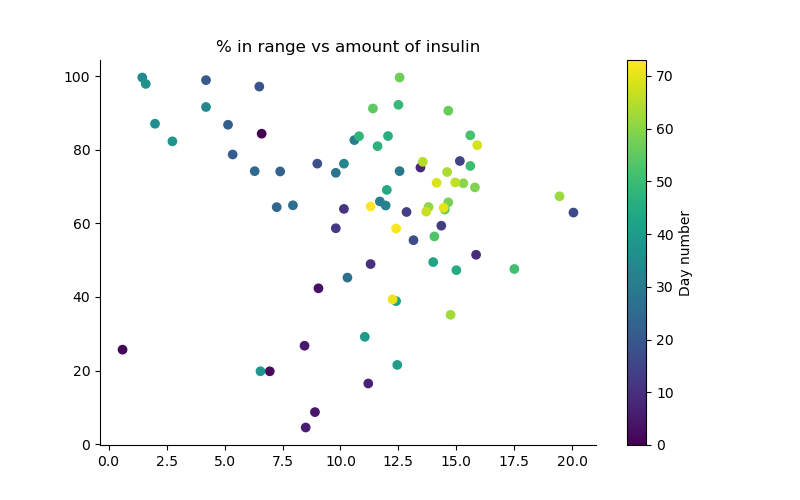

In [9]:
fig3, ax3 = plt.subplots(1,1, figsize=(8,5))

df_cgm_summary["daynum"] = np.arange(0,len(df_cgm_summary))

ins = ax3.scatter(df_insulin["total_insulin"][::-1], 
            df_cgm_summary["pct_inrange"], 
            c=df_cgm_summary["daynum"])

ax3.set_title("% in range vs amount of insulin")

sns.despine(left=False, bottom=False,ax=ax3)

plt.colorbar(ins, label="Day number");

It's hard to say whether there are any patterns in the plot above. Time in range is clearly better for the more recent days (greens and yellows), but it's hard to see what the correlations might be between time-in-range and insulin amount. To try to tease out patterns, I made a little summary file (in the data folder) that notes when certain things were happening (things I think may be important to her time in range). 

In [10]:
summary_file = r"../data/date_notes.csv"
df_summ = pd.read_csv(summary_file)
df_summ["date"] = pd.to_datetime(df_summ["date"])

# map "notes" to dates in the CGM daily summary
df_cgm_summary["status"] = df_cgm_summary["time"].map(dict(zip(df_summ["date"], df_summ["note"])))

# Add total insulin column to the daily summary to make plotting easier
df_cgm_summary["total_insulin"] = df_insulin["total_insulin"].tolist()[::-1]

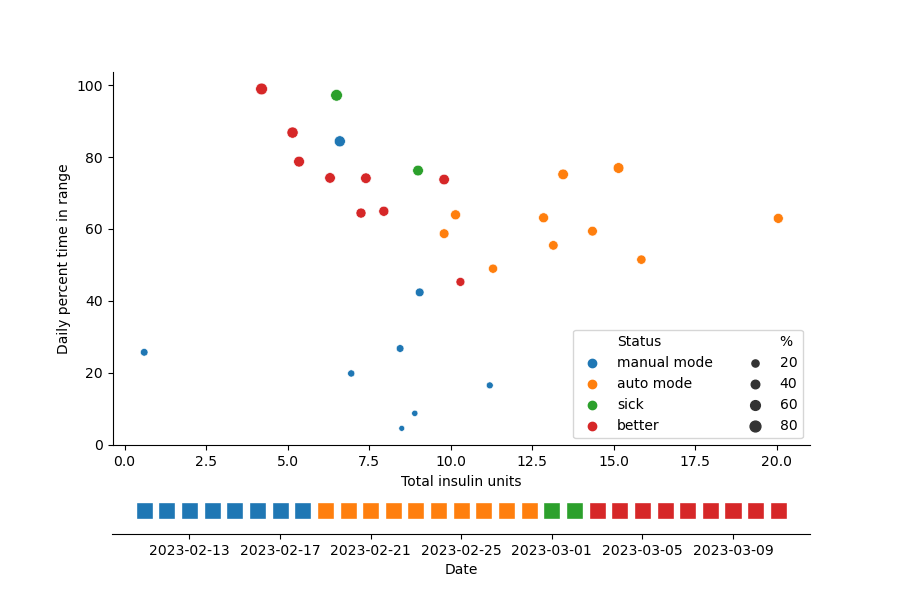

In [11]:
#fig4, ax4 = plt.subplots(1,1, figsize=(8,6))
fig4, (ax4, ax5) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8,1]}, figsize=(9,6))


p1 = sns.scatterplot(data=df_cgm_summary, 
                x="total_insulin", y="pct_inrange",
                hue="status", size="pct_inrange", legend="brief",
                ax=ax4)

sns.despine(left=False, bottom=False,ax=ax4)
ax4.set_xlabel("Total insulin units")
ax4.set_ylabel("Daily percent time in range")
ax4.legend(ncol=2)
#leg = ax4.get_legend()
ax4.get_legend().texts[0].set_text('Status')
ax4.get_legend().texts[5].set_text('%')
#plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


# Timeline
sns.scatterplot(df_cgm_summary, x="time", y=np.ones(len(df_cgm_summary)), 
                hue="status", ax=ax5, legend=False, marker="s", s=150)
sns.despine(left=True, bottom=False,ax=ax5)
ax5.set_xlabel("Date")
ax5.set_yticks([]);         
                                                 

# 